In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff7 as ds
from copy import copy as dup
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from numba import int64
#from numba import int32

#for 3d plots
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
#for 3d plots
import matplotlib.animation as animation

#for saving animations
import pickle

C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


This notebook is to save the solve_ivp version that was nearly complete- the issue is that the solve_ivp function requires an event function that returns a float, and the event will trigger when it is a zero, however the event has to be a continuous function of y and t to solve for the zeros. However, the event function we use to stop when enough layers are grown is a boolean based off calculations using the history of layer thickness, and therefore the event function is not continuous.
-@mbloom0

In [2]:
# Graphics parameters
%matplotlib widget
ticklabelsize = 15
fontsize = 15
linewidth = 2
fignum = 0

In [3]:
# These are run control parameters
""" Fliq is the QLL (shape: nx)
    Ntot is the the combined values of the ice layers (Nice), combined with the QLL layer (Nliq or Fliq or NQLL variously referred to as)
        Ntot is shaped (2, nx)
"""

noisy_init = False
noise_std_dev = 0.01

# Flag for explicit updating Fliq(Ntot) every step 
updatingFliq = True
# Set up a maximum number of iterations or layers
uselayers = True

if uselayers:
    layermax_0D = 4
    layermax_1D = 5#0
    layermax_2D = 30
else:
    countermax_0D = 100
    countermax_1D = 15000
    countermax_2D = 1000#15000

In [4]:
# File loading variables
lastfile = 'NeshData/continuum_model6 28-5-2016[1][1].npz'; Load_old_file = False
nextfile = 'NeshData/continuum_model6 28-5-2016[1][1].npz'; Save_new_file = False
trajfile = 'NeshData/continuum_model6 28-5-2016[1][1].traj.npz'; trajflag = False
traj0file= 'NeshData/continuum_model6 28-5-2016[1][1].traj0.npz'; traj0flag = False

In [5]:
#Setting up the system
# Number of iterations to calculate Nliq from Ntot (Increased niter means more iterative calculation: converges on greater accuracy at cost of time)
niter = 1

# Loading/initializing state
if Load_old_file:  #load an old system
    print("loading", lastfile)
    npzfile = np.load(lastfile)
    Fliq = npzfile['Fliq']
    Nice = npzfile['Nice']
    Nbar = npzfile['Nbar']
    Nstar = npzfile['Nstar']
    x = npzfile['x']
    nx = len(x)
    deltaX = x[1]-x[0]
else:
    #new system
    nx = 500 # Number of points in simulation box
    xmax = 50 # range of x
    x = np.linspace(0, xmax, nx)
    
    deltaX = x[1]-x[0]
    Nbar = 1.0 # new Nbar from VMD, 260K
    Nstar = .9/(2*np.pi)
    # Initialize as a pre-equilibrated layer of liquid over ice
    Nice = np.ones(nx)

    if noisy_init:
        # Initialize with noise
        noise = np.random.normal(0,noise_std_dev,nx)
        Nice += noise

    
    Fliq = ds.getNliq_array(Nice,Nstar,Nbar,niter)

# Lay out the system
Ntot = Fliq + Nice
nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]
#Niceoffset = ds.getNiceoffset(Nbar, Nstar, 1, 0) # Should be close to .75; not used if D=const #NOTE: this is unused

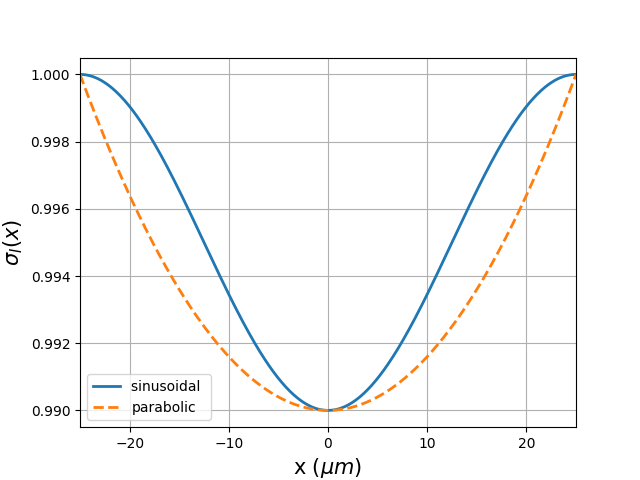

In [6]:
#Time and diffusion parameters
# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 10
dtmaxtimefactor = 50
dtmax = deltaX**2/D
deltaT = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltaT = deprate * deltaT

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 #-0.10 # Must be bigger than sigma0 to get growth, less than 0 for ablation
center_reduction = 1.0 #0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

# Gets the function sigma(x)
sigmastep_sinusoid = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='sinusoid') 
sigmastep_parabolic = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='parabolic')
sigmastepstyle = 'parabolic'
if sigmastepstyle=='sinusoid':
    sigmastep = sigmastep_sinusoid
elif sigmastepstyle=='parabolic':
    sigmastep = sigmastep_parabolic
else:
    print('bad choice')

# Graph sigma(x)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid,sigmastep_sinusoid/sigmastepmax, \
         x-xmid, sigmastep_parabolic/sigmastepmax, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

In [7]:
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltaT_max (Diffusion time)', dtmax)
print('deltaT =', deltaT)
print('deprate =', deprate, 'monolayers/us')
print('nmid', nmid)
print('N*', Nstar)
print('N*x2pi', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltaX', deltaX)
print('sigma_0 =', sigma0)
print('sigmastepmax =', sigmastepmax)
print('center reduction', center_reduction, '%')
print('max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')

D = 0.0002 um^2/us 0.2 x 10^-9 m^2/sec
deltaT_max (Diffusion time) 50.20060160400962
deltaT = 1.0040120320801924
deprate = 0.16333333333333333 monolayers/us
nmid 250
N* 0.1432394487827058
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.8567605512172942 0.1432394487827058
deltaX 0.10020040080160321
sigma_0 = 0.19
sigmastepmax = 0.2
center reduction 1.0 %
max growth rate = 9.8 um/sec
min growth rate = 0.49000000000000044 um/sec
nu_kin = 49 um/sec


In [12]:
#Setting up the 2D system

nx = 500 # Number of points in simulation box
xmax = 50 # range of x
x = np.linspace(0, xmax, nx)

ny = nx
ymax = xmax
y = np.linspace(0, ymax, ny)

deltaX = x[1]-x[0]
deltaY = y[1]-y[0]

Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)
# Initialize as a pre-equilibrated layer of liquid over ice

Nice = np.ones((nx,ny))

if noisy_init:
    # Initialize with noise
    noise = np.random.normal(0,noise_std_dev,(nx,ny))
    Nice += noise


Fliq = ds.getNliq_2d_array(Nice,Nstar,Nbar,niter)

sigmastep_2d = ds.getsigmastep_2d(x,y,center_reduction,sigmastepmax)



# Lay out the system
Ntot = Fliq + Nice
# nmid = int(nx/2)
# nquart = int(nx/4)
# xmid = max(x)/2
# xmax = x[nx-1]
Nice_start = Nice[0]

#Niceoffset = ds.getNiceoffset(Nbar, Nstar, 1, 0) # Should be close to .75; not used if D=const #NOTE: this is unused

In [14]:
# # This is the 2-d run using solve_ivp #NOTE: does not integrate well wit termionation based on layer count

# # Bundle parameters for ODE solver

# float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])
# int_params = np.array(list(map(int64,[niter,nx,ny]))) # f2d requires int64

# # Initial conditions for ODE solver
# y0 = np.array([Fliq,Ntot])
# ylast = dup(y0)

# #for calculating layers
# Ntot0_start = Ntot[0,0]
# Ntot0 = Ntot[0,0]
# updatingFliq = True

# countermax_2D = 15000

# # Time steps
# tmax = countermax_2D*deltaT
# t0 = 0.0
# tinterval = [t0, tmax]

# # Call the ODE solver
# layer = 0

# # def event(t,y) -> float: NOTE: this does not cause solve_ivp to halt when enough layers are grown
# #     """ Event function for ODE solver. Equals zero when the goal number of layers is reached
# #      or the maximum number of iterations is reached, causing the solver to stop. """
# #     event.terminal = True
# #     # Test whether we're finished

# #     Fliq, Ntot = np.reshape(np.ascontiguousarray(y),(2,nx,ny))
# #     Ntot0 = Ntot[0,0]

# #     if updatingFliq:#TODO: i dont think the event function can influence the y array in the solve_ivp function
# #         #NOTE: this seems to not affect results of 2d model
# #         Fliq = ds.getNliq_2d_array(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
# #         Fliq, Ntot = ylast

# #     if uselayers:
# #         layer = Ntot0-Ntot0_start
# #         # Update counters and see whether to break
# #         print("appx progress:" , round((layer/(layermax_2D-1))*100, 2),"%",end="\r")
# #         if sigmastepmax > 0:#growth regime
# #             #if layer > layermax_2D-1:
# #             terminate = layer - layermax_2D # solve_ivp tries to solve for zero
# #             #as t increases, the layer will increase, and the layermax will be reached
# #             #thus terminate will equal zero and the ivp solver will stop
# #             if terminate == 0:
# #                 print('breaking because reached max number of layers grown')
# #         else:#ablation regime
# #             #if layer < -layermax_2D:
# #             terminate = layer + layermax_2D
# #             #as t increases, the layer will decrease, and the layermax will be reached
# #             if terminate == 0:
# #                 print('breaking because reached max number of layers ablated')
# #     else:
# #         if counter > countermax_2D-1:
# #             print('breaking because reached max number of iterations')
# #             terminate = 0
# #     return terminate

# ode_solution_dict = solve_ivp(ds.f2d_ivp, tinterval, np.reshape(ylast,np.prod(np.shape(ylast))),
#                              args=(float_params,int_params,sigmastep_2d), rtol=1e-12)#, events=lambda t,x,*args:event(t,x))

In [17]:
#Solve ivp solution repackaging
#num_steps = len(ode_solution_dict['t'])
#print(num_steps)
#solution_array = np.reshape(ode_solution_dict['y'],(num_steps,2,nx,ny))

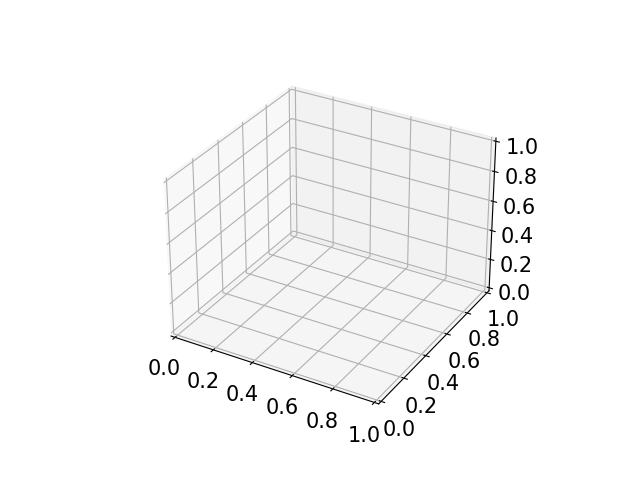

In [18]:
#Plotting the solve_ivp results
animate = True
save_results_img_gif = True
save_figure_pickle = False

#create coordinate arrays for plotting
x = np.linspace(0, xmax, nx)
y = np.linspace(0, ymax, ny)
xs, ys = np.meshgrid(x, y)

fignum +=1
fig = plt.figure(fignum)
ax = plt.axes(projection='3d')

# was for solve_ivp
# num_steps = len(ode_solution_dict['t'])
# solution_array = np.reshape(ode_solution_dict['y'],(2,nx,ny))
# Fliq,Ntot = solution_array

if animate:
    #3d animation of the results
    def update_surface(num):
        ax.clear() # remove last iteration of plot 
        #labels
        ax.set_xlabel(r'$x (\mu m$)',fontsize=fontsize)
        ax.set_ylabel(r'$y (\mu m$)',fontsize=fontsize)
        ax.set_zlabel(r'$ice \ layers$',fontsize=fontsize)
        #limits
        ax.set_zlim3d(-layermax_2D, layermax_2D)
        ax.set_ylim(0, ymax)
        ax.set_xlim(0, xmax)
        #surface plot
        xmid = round(np.shape(Nice)[0]/2)
        #ax.plot_surface(X=xs[xmid:], Y=ys[xmid:], Z=Nicekeep[num][xmid:][:], cmap='viridis')#, vmin=0, vmax=200) #plot half of the surface of the ice  
        #ax.plot_surface(X=xs[xmid:], Y=ys[xmid:], Z=Ntotkeep[num][xmid:][:], cmap='YlGnBu_r')#, vmin=0, vmax=200) #plot half the surface of the QLL
        ax.plot_surface(X=xs, Y=ys, Z=Nicekeep[num], cmap='viridis')#, vmin=0, vmax=200) #plot the surface of the ice 
        #ax.plot_surface(X=xs, Y=ys, Z=Ntotkeep[num], cmap='YlGnBu_r')#, vmin=0, vmax=200)#plot the surface of the QLL
        #ax.plot_surface(X=xs, Y=ys, Z=solution_array[num], cmap='YlGnBu_r')#, vmin=0, vmax=200)#plot the surface of the QLL    #for solve_ivp

        # plot = ax.plot_surface(X=xs, Y=ys, Z=Nicekeep[num], cmap='viridis')#, vmin=0, vmax=200) #plot the surface of the ice  
        # plot = ax.plot_surface(X=xs, Y=ys, Z=Ntotkeep[num], cmap='YlGnBu_r')#, vmin=0, vmax=200)#plot the surface of the QLL
        # return plot
        pass
    ani = animation.FuncAnimation(fig, update_surface, num_steps, interval=100, blit=False, cache_frame_data=False, repeat = True)
else:
    #3d plot of the results
    #surface plot
    plot = ax.plot_surface(X=xs, Y=ys, Z=Nice, cmap='viridis')#, vmin=0, vmax=200)
    plot = ax.plot_surface(X=xs, Y=ys, Z=Ntot, cmap='YlGnBu_r')#, vmin=0, vmax=200)
    
    #countour plot
    # levels = np.arange(-6,12,0.25)
    # ax.contour(x,y, Nice, extent=(0, 2, 0, 2), cmap='YlGnBu_r', vmin=0, vmax=200, zorder=1, levels=levels)

plt.show()

#Save the results
filename = '3d_model_results_'+str(layermax_2D)+'_layers'
if save_results_img_gif and animate:
    #File writer for saving animations as gifs
    writergif = animation.PillowWriter(fps=480, bitrate=1800)
    ani.save(filename+'.gif',writer=writergif)
    #File writer for saving animations as mp4
    # writervideo = animation.FFMpegWriter(fps=60)
    # ani.save('3d_model.mp4', writer=writervideo)
elif save_results_img_gif and not animate:
    #Save the results as an image
    plt.savefig(filename+'.png', dpi=300)

if save_figure_pickle:
    serialized_fig = pickle.dumps(fig)
    pickle_filename = '2d_model_3d_results_fig_8-3-22.pkl'
    with open(pickle_filename, 'wb') as f:
        pickle.dump(serialized_fig, f)

In [ ]:
#Optional code after plotting animation 
#plt.close() 

load_pickle = False #note this loads an image right now not an interactive figure
if load_pickle:
    with open(pickle_filename, 'rb') as f:
        serialized_fig = pickle.load(f)
    plt.figure()
    fig = pickle.loads(serialized_fig)
    plt.show()
    plt.close()